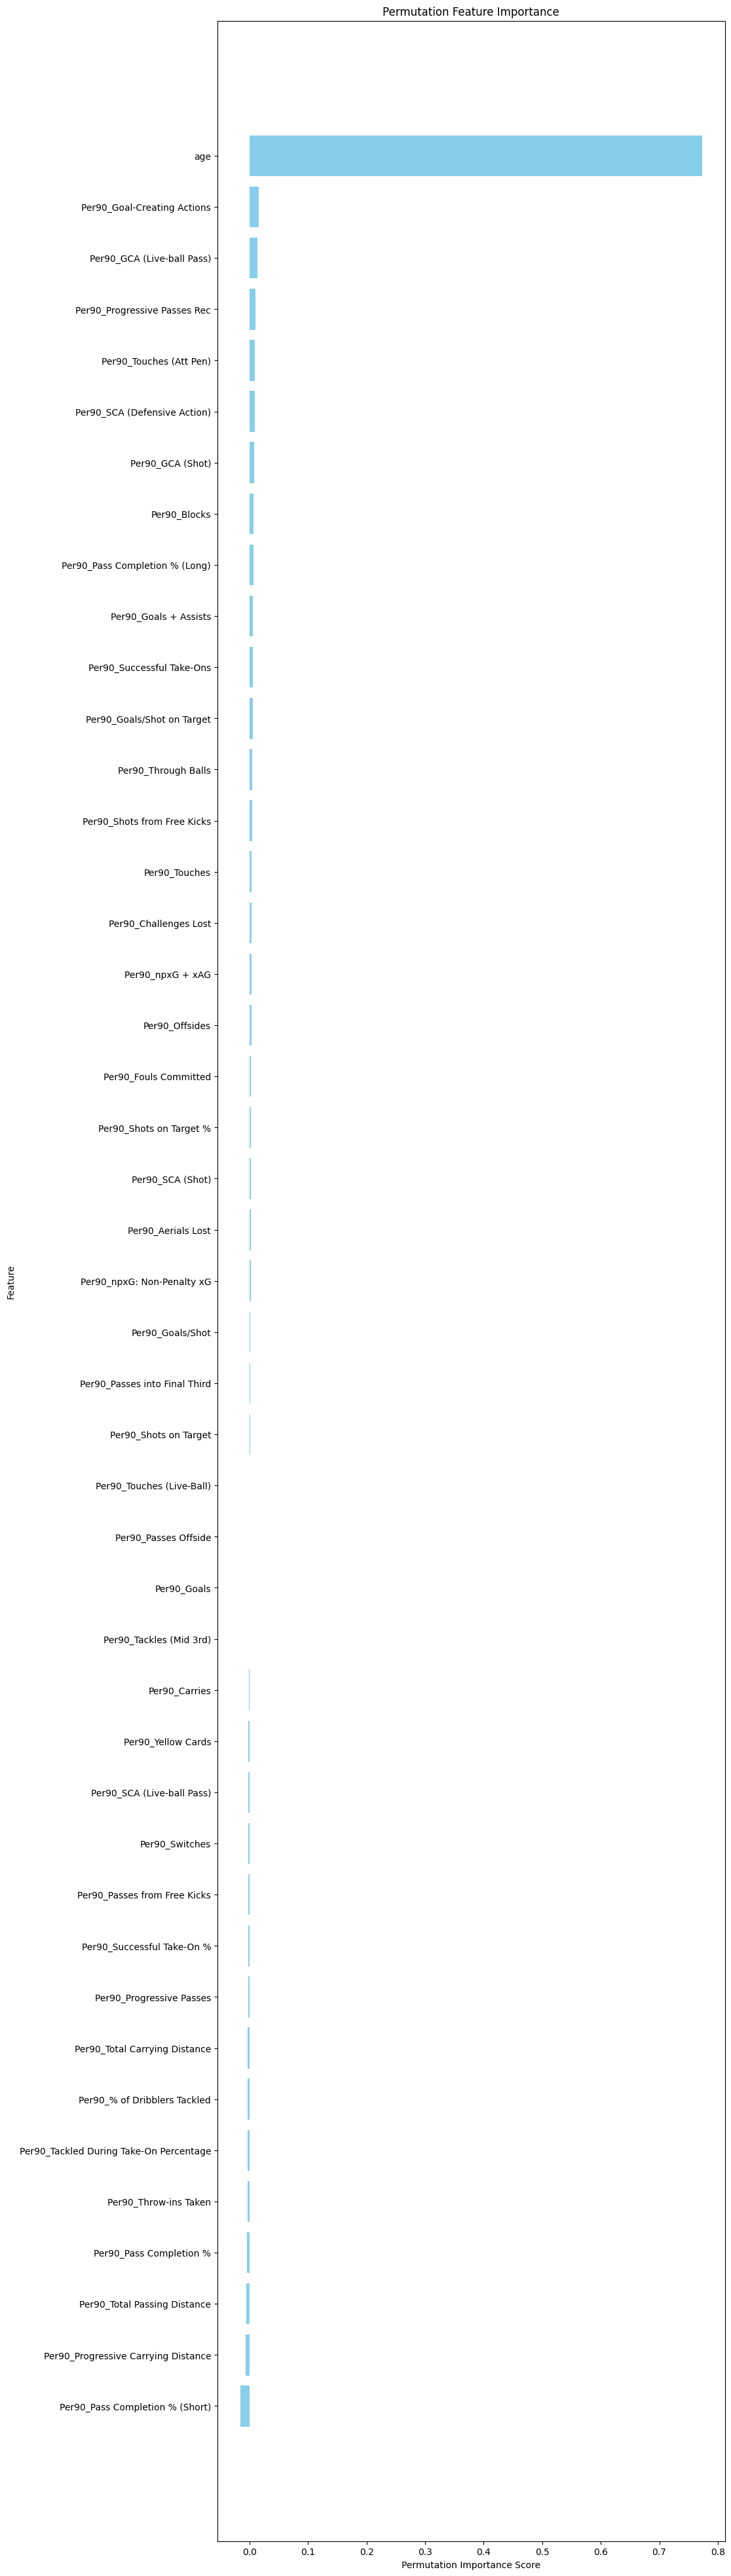

📌 Mean Absolute Error (MAE): 0.52
📌 Mean Squared Error (MSE): 0.43
📌 R² Score: 0.64


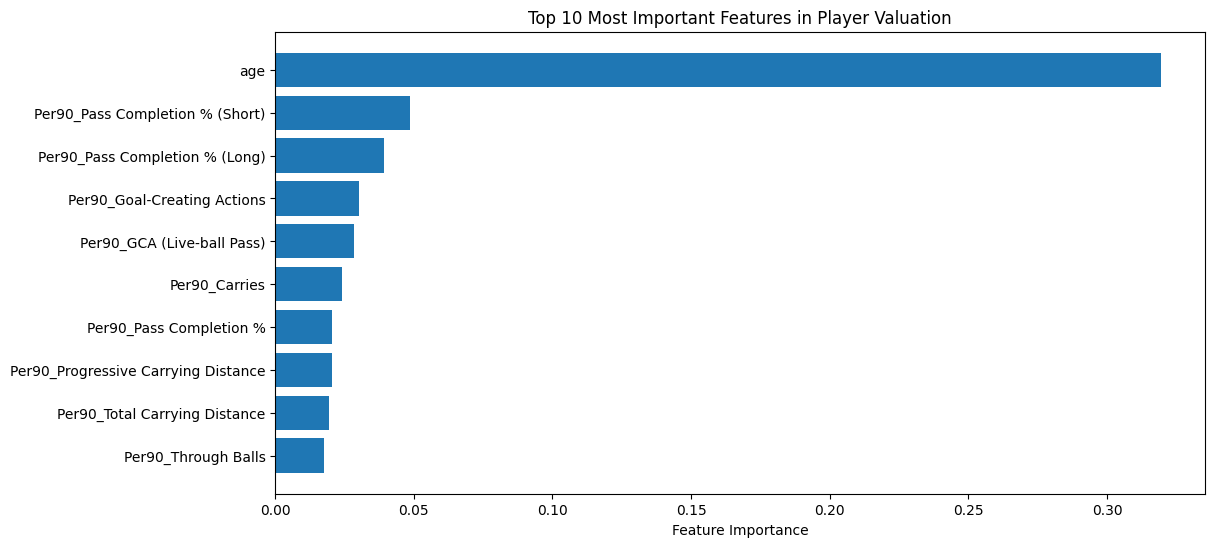

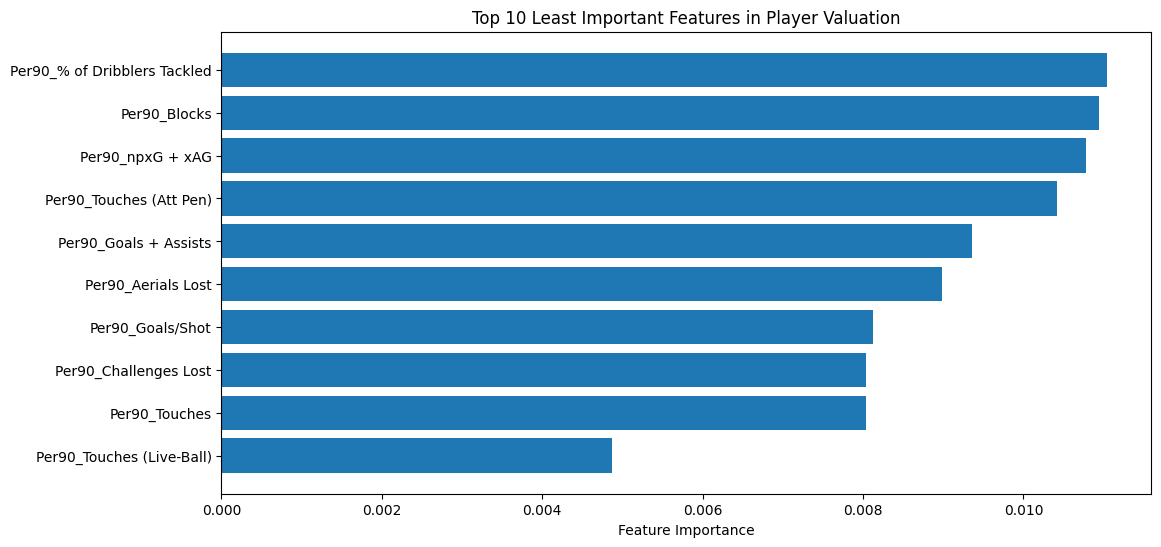

In [8]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance


# Load the Dataset
file_path = "preprocessed_data/outfield_processed.csv"  
df = pd.read_csv(file_path)

# Define Features (X) and Target (y)
X = df.drop(columns=["Player", "player_market_value_euro"], errors="ignore")  
y = df["player_market_value_euro"]

# Split Data into Training and Testing Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Model
rf_model = RandomForestRegressor(n_estimators=82, random_state=42)
rf_model.fit(X_train, y_train)

# Perform Permutation Importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Convert results to a DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)
# Plot Permutation Importance
plt.figure(figsize=(10, 50))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Permutation Importance Score')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Make Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📌 Mean Absolute Error (MAE): {mae:.2f}")
print(f"📌 Mean Squared Error (MSE): {mse:.2f}")
print(f"📌 R² Score: {r2:.2f}")

# Feature Importance Analysis
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx[:10])), feature_importance[sorted_idx[:10]], align='center')
plt.yticks(range(len(sorted_idx[:10])), [X.columns[i] for i in sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features in Player Valuation")
plt.gca().invert_yaxis()
plt.show()

# show bottom 10 features
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx[-10:])), feature_importance[sorted_idx[-10:]], align='center')
plt.yticks(range(len(sorted_idx[-10:])), [X.columns[i] for i in sorted_idx[-10:]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Least Important Features in Player Valuation")
plt.gca().invert_yaxis()
plt.show()
